In [1]:
import os
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import imageio
import torch
from torch import nn, optim

In [2]:
trial_dir = os.path.join('.', 'results', 'toy_invariance_experiment')
os.makedirs(trial_dir, exist_ok=True)
invariant_stds = np.linspace(1.0, 0.0, 100)
spurious_stds = np.linspace(0.0, 1.0, 100)
rerun_dataset_visualization_trials = False
rerun_naive_trials = False
rerun_ccbn_trials = True

In [3]:
class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self, invariant_std, spurious_std, samples_per_class=500):
        super().__init__()
        
        fake_A_mean = np.array([1.0, 1.0])
        fake_B_mean = np.array([1.0, 1.0])
        real_A_mean = np.array([-1.0, 0.0])
        real_B_mean = np.array([-1.0, -1.0])
        stds = np.array([invariant_std, spurious_std])
        self.x = np.concatenate((
            np.random.normal(fake_A_mean, stds, (samples_per_class//2, 2)),
            np.random.normal(fake_B_mean, stds, (samples_per_class//2, 2)),
            np.random.normal(real_A_mean, stds, (samples_per_class//2, 2)),
            np.random.normal(real_B_mean, stds, (samples_per_class//2, 2))
        ))
        self.y_invariant = np.concatenate((
            np.zeros((samples_per_class,)),
            np.ones((samples_per_class,))
        ))
        self.y_spurious = np.concatenate((
            np.ones((samples_per_class//2,)),
            np.zeros((samples_per_class//2,)),
            np.ones((samples_per_class//2,)),
            np.zeros((samples_per_class//2,))
        ))
        self.samples = 2*samples_per_class
        self.invariant_std = invariant_std
        self.spurious_std = spurious_std
        
    def __getitem__(self, idx):
        x, y_invariant, y_spurious = self.x[idx], self.y_invariant[idx], self.y_spurious[idx]
        x = torch.from_numpy(x).to(torch.float)
        y_invariant = torch.tensor(y_invariant).to(torch.long)
        y_spurious = torch.tensor(y_spurious).to(torch.long)
        return x, y_invariant, y_spurious
    
    def __len__(self):
        return self.samples

In [4]:
def visualize_dataset(invariant_std=None, spurious_std=None, dataset=None):
    if dataset is None:
        assert (invariant_std is not None) and (spurious_std is not None)
        dataset = GaussianDataset(invariant_std, spurious_std)
    else:
        invariant_std = dataset.invariant_std
        spurious_std = dataset.spurious_std
    (fig, ax) = plt.subplots()
    ax.plot(dataset.x[np.all((dataset.y_invariant==0, dataset.y_spurious==0), axis=0)][:, 0],
            dataset.x[np.all((dataset.y_invariant==0, dataset.y_spurious==0), axis=0)][:, 1],
            'x', color='red', label='Fake (A)'
    )
    ax.plot(dataset.x[np.all((dataset.y_invariant==0, dataset.y_spurious==1), axis=0)][:, 0],
            dataset.x[np.all((dataset.y_invariant==0, dataset.y_spurious==1), axis=0)][:, 1],
            'o', color='red', label='Fake (B)'
    )
    ax.plot(dataset.x[np.all((dataset.y_invariant==1, dataset.y_spurious==0), axis=0)][:, 0],
            dataset.x[np.all((dataset.y_invariant==1, dataset.y_spurious==0), axis=0)][:, 1],
            'x', color='blue', label='Real (A)'
    )
    ax.plot(dataset.x[np.all((dataset.y_invariant==1, dataset.y_spurious==1), axis=0)][:, 0],
            dataset.x[np.all((dataset.y_invariant==1, dataset.y_spurious==1), axis=0)][:, 1],
            'o', color='blue', label='Real (B)'
    )
    ax.axvline(x=0, linestyle='--', color='black', label='Invariant decision boundary')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(-5, 6))
    ax.set_yticks(np.arange(-5, 6))
    ax.grid(True)
    ax.legend(loc='lower right')
    ax.set_xlabel('Invariant feature')
    ax.set_ylabel('Spurious feature')
    ax.set_title('Invariant/spurious std. dev.: %0.2f/%0.2f'%(invariant_std, spurious_std))
    return fig

def generate_animation(dest, src):
    frame_files = os.listdir(src)
    sorted_indices = np.argsort([float(f.split('.')[0].split('_')[-1]) for f in frame_files])
    frame_files = [frame_files[idx] for idx in sorted_indices]
    with imageio.get_writer(dest, mode='I', duration=10/len(frame_files)) as writer:
        for frame_file in frame_files:
            image = imageio.imread(os.path.join(src, frame_file))
            writer.append_data(image)

In [5]:
if rerun_dataset_visualization_trials:
    frame_dir = os.path.join(trial_dir, 'dataset_visualization', 'frames')
    fig_dir = os.path.join(trial_dir, 'dataset_visualization', 'figures')
    os.makedirs(frame_dir, exist_ok=True)
    os.makedirs(fig_dir, exist_ok=True)
    for idx, (invariant_std, spurious_std) in tqdm(enumerate(zip(invariant_stds, spurious_stds)), total=len(invariant_stds)):
        fig = visualize_dataset(invariant_std, spurious_std)
        fig.savefig(os.path.join(frame_dir, 'frame_{}.jpg'.format(idx)), dpi=50)
        plt.close(fig)
    generate_animation(os.path.join(fig_dir, 'anim.gif'), frame_dir)

In [6]:
def hinge_loss(logits, y):
    return nn.functional.relu(1-y*logits).mean()

def train_linear_model(invariant_std=None, spurious_std=None, dataset=None, n_epochs=100, batch_size=32):
    if dataset is None:
        assert (invariant_std is not None) and (spurious_std is not None)
        dataset = GaussianDataset(invariant_std, spurious_std)
    model = nn.Linear(2, 1)
    dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    for epoch in range(n_epochs):
        for batch in dataloader:
            x, y, _ = batch
            logits = model(x).squeeze()
            loss = nn.functional.binary_cross_entropy(torch.sigmoid(logits), y.to(torch.float))
            opt.zero_grad()
            loss.backward()
            opt.step()
    return lambda x: model(torch.from_numpy(x).to(torch.float)).detach().squeeze().numpy()

def display_decision_boundary(fig, model, n=100):
    ax = fig.axes[0]
    xx, yy = np.meshgrid(*[np.linspace(-5, 5, n) for _ in range(2)])
    zz = model(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, zz, colors=['red', 'blue'], alpha=0.25, levels=1)

In [7]:
if rerun_naive_trials:
    frame_dir = os.path.join(trial_dir, 'naive_decision_boundaries', 'frames')
    fig_dir = os.path.join(trial_dir, 'naive_decision_boundaries', 'figures')
    os.makedirs(frame_dir, exist_ok=True)
    os.makedirs(fig_dir, exist_ok=True)
    for idx, (invariant_std, spurious_std) in tqdm(enumerate(zip(invariant_stds, spurious_stds)), total=len(invariant_stds)):
        dataset = GaussianDataset(invariant_std, spurious_std)
        fig = visualize_dataset(dataset=dataset)
        model = train_linear_model(dataset=dataset)
        display_decision_boundary(fig, model)
        fig.savefig(os.path.join(frame_dir, 'frame_{}.jpg'.format(idx)), dpi=50)
        plt.close(fig)
    generate_animation(os.path.join(fig_dir, 'anim.gif'), frame_dir)

In [8]:
def visualize_ccbn_dataset(invariant_std=None, spurious_std=None, dataset=None):
    if dataset is None:
        assert (invariant_std is not None) and (spurious_std is not None)
        dataset = GaussianDataset(invariant_std, spurious_std)
    else:
        invariant_std = dataset.invariant_std
        spurious_std = dataset.spurious_std
    fake_A, fake_B, real_A, real_B = [], [], [], []
    for x, y_i, y_s in dataset:
        if y_i == y_s == 0:
            fake_A.append(x.numpy())
        elif y_i == 0 and y_s == 1:
            fake_B.append(x.numpy())
        elif y_i == 1 and y_s == 0:
            real_A.append(x.numpy())
        elif y_i == y_s == 1:
            real_B.append(x.numpy())
    fake_A, fake_B, real_A, real_B = torch.tensor(fake_A), torch.tensor(fake_B), torch.tensor(real_A), torch.tensor(real_B)
    real = class_conditional_bn(torch.cat((real_A, real_B), dim=0),
                                torch.cat((torch.ones(len(real_A)), -torch.ones(len(real_A))), dim=0))
    real_A, real_B = torch.split(real, len(real)//2)
    real_A, real_B = real_A.numpy(), real_B.numpy()
    (fig, ax) = plt.subplots()
    ax.plot(fake_A[:, 0], fake_A[:, 1],
            'x', color='red', label='Fake (A)'
    )
    ax.plot(fake_B[:, 0], fake_B[:, 1],
            'o', color='red', label='Fake (B)'
    )
    ax.plot(real_A[:, 0], real_A[:, 1],
            'x', color='blue', label='Real (A)'
    )
    ax.plot(real_B[:, 0], real_B[:, 1],
            'o', color='blue', label='Real (B)'
    )
    ax.axvline(x=0, linestyle='--', color='black', label='Invariant decision boundary')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(-5, 6))
    ax.set_yticks(np.arange(-5, 6))
    ax.grid(True)
    ax.legend(loc='lower right')
    ax.set_xlabel('Invariant feature')
    ax.set_ylabel('Spurious feature')
    ax.set_title('Invariant/spurious std. dev.: %0.2f/%0.2f'%(invariant_std, spurious_std))
    return fig

def class_conditional_bn(features, y):
    mn = 0.0
    std = 1.0
    for yy in torch.unique(y):
        mn_yy = features[y==yy].mean(dim=0, keepdim=True)
        features[y==yy] -= mn_yy
        std_yy = features[y==yy].std(dim=0, keepdim=True)
        mn += mn_yy
        std *= std_yy
    mn = mn / len(torch.unique(y))
    std = std ** (1/len(torch.unique(y)))
    features = std*features + mn
    return features

def train_ccbn_linear_model(invariant_std=None, spurious_std=None, dataset=None, n_epochs=100, batch_size=32):
    if dataset is None:
        assert (invariant_std is not None) and (spurious_std is not None)
        dataset = GaussianDataset(invariant_std, spurious_std)
    model = nn.Linear(2, 1)
    dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    for epoch in range(n_epochs):
        for batch in dataloader:
            x, y_invariant, y_spurious = batch
            x = class_conditional_bn(x, y_spurious)
            logits = model(x).squeeze()
            loss = nn.functional.cross_entropy(torch.sigmoid(logits), y_invariant)
            opt.zero_grad()
            loss.backward()
            opt.step()
    return lambda x: model(torch.from_numpy(x).to(torch.float)).detach().squeeze().numpy()

  0%|                                                                                                                                                              | 0/100 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

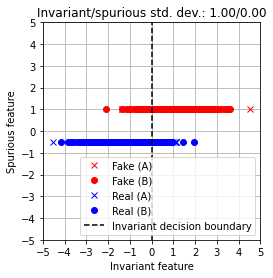

In [9]:
if rerun_ccbn_trials:
    frame_dir = os.path.join(trial_dir, 'ccbn_decision_boundaries', 'frames')
    fig_dir = os.path.join(trial_dir, 'ccbn_decision_boundaries', 'figures')
    os.makedirs(frame_dir, exist_ok=True)
    os.makedirs(fig_dir, exist_ok=True)
    for idx, (invariant_std, spurious_std) in tqdm(enumerate(zip(invariant_stds, spurious_stds)), total=len(invariant_stds)):
        dataset = GaussianDataset(invariant_std, spurious_std)
        fig = visualize_ccbn_dataset(dataset=dataset)
        model = train_ccbn_linear_model(dataset=dataset)
        display_decision_boundary(fig, model)
        fig.savefig(os.path.join(frame_dir, 'frame_{}.jpg'.format(idx)), dpi=50)
        plt.close(fig)
    generate_animation(os.path.join(fig_dir, 'anim.gif'), frame_dir)